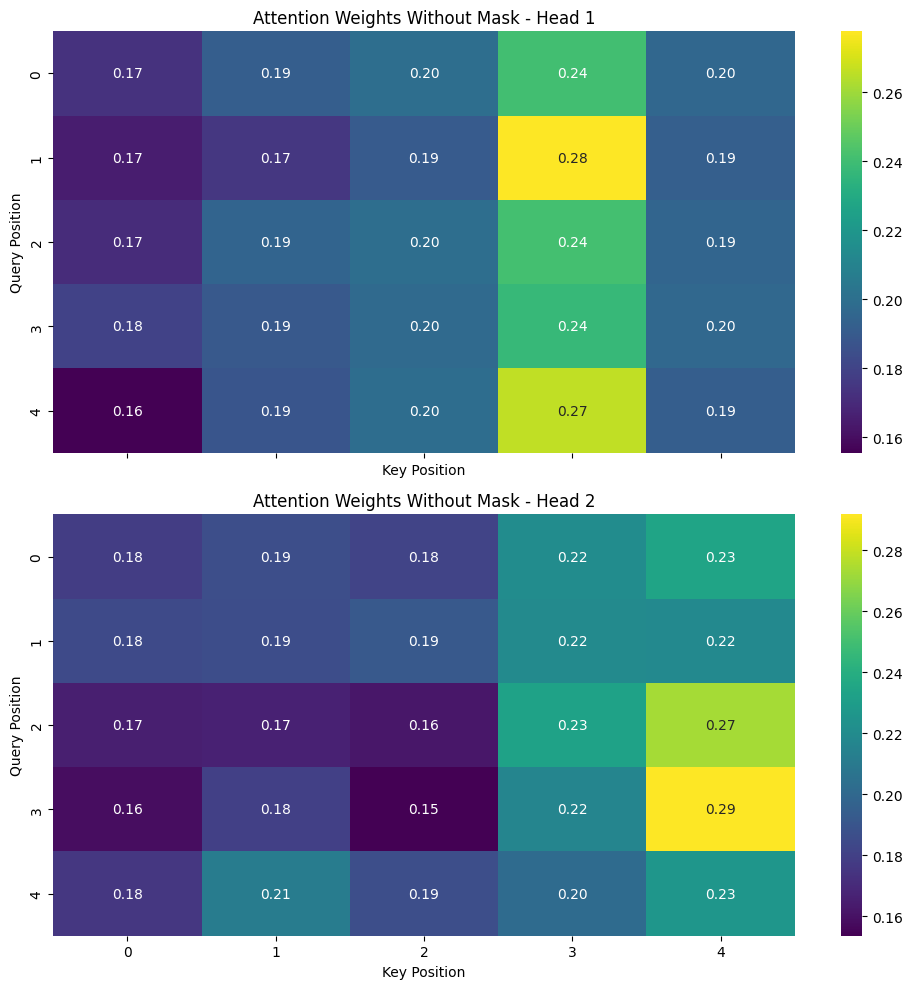

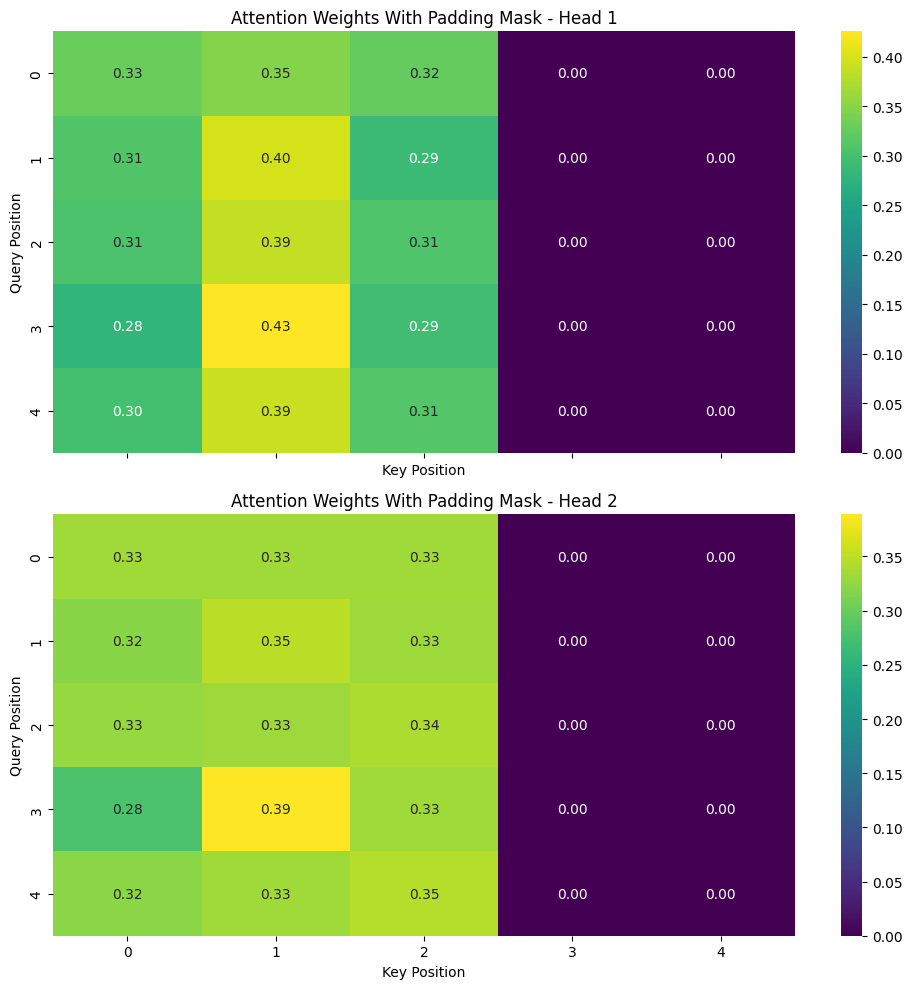

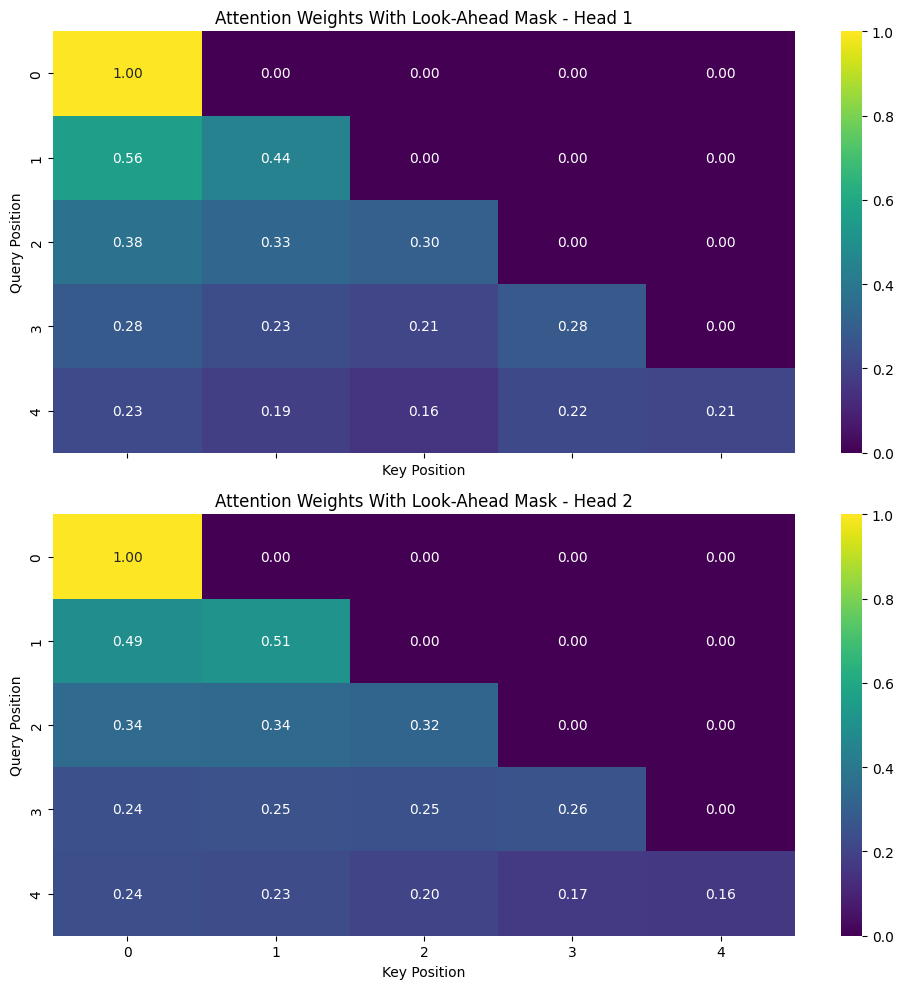

[[[[0. 0. 0. 1. 1.]]]]
[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]


In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to split heads
def split_heads(x, num_heads, depth):
    x = tf.reshape(x, (tf.shape(x)[0], -1, num_heads, depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

# Function to compute scaled dot-product attention
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

# Function to create the Multi-Head Attention mechanism
def multi_head_attention(v, k, q, num_heads, d_model, mask=None):
    depth = d_model // num_heads
    
    wq = tf.keras.layers.Dense(d_model)
    wk = tf.keras.layers.Dense(d_model)
    wv = tf.keras.layers.Dense(d_model)
    dense = tf.keras.layers.Dense(d_model)
    
    q = wq(q)  # Transform queries
    k = wk(k)  # Transform keys
    v = wv(v)  # Transform values
    
    q = split_heads(q, num_heads, depth)  # Split heads
    k = split_heads(k, num_heads, depth)  # Split heads
    v = split_heads(v, num_heads, depth)  # Split heads
    
    output, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    
    output = tf.transpose(output, perm=[0, 2, 1, 3])
    concat_attention = tf.reshape(output, (tf.shape(output)[0], -1, d_model))
    output = dense(concat_attention)
    
    return output, attention_weights

# Function to plot attention weights
def plot_attention_weights(attention_weights, title):
    num_heads = attention_weights.shape[1]
    fig, axes = plt.subplots(num_heads, 1, figsize=(10, 10), sharex=True, sharey=True)
    
    for i in range(num_heads):
        ax = axes[i]
        sns.heatmap(tf.squeeze(attention_weights[0][i]), annot=True, fmt=".2f", cmap='viridis', ax=ax)
        ax.set_title(f"{title} - Head {i+1}")
        ax.set_xlabel('Key Position')
        ax.set_ylabel('Query Position')
    
    plt.tight_layout()
    plt.show()

# Create example data
batch_size = 1
seq_len = 5
d_model = 8
num_heads = 2

np.random.seed(1)
queries = np.random.rand(batch_size, seq_len, d_model).astype(np.float32)
keys = np.random.rand(batch_size, seq_len, d_model).astype(np.float32)
values = np.random.rand(batch_size, seq_len, d_model).astype(np.float32)

# Perform Multi-Head Attention
output_no_mask, attention_weights_no_mask = multi_head_attention(values, keys, queries, num_heads, d_model, mask=None)
plot_attention_weights(attention_weights_no_mask, "Attention Weights Without Mask")

# Padding mask
seq = np.array([[1, 2, 3, 0, 0]])
padding_mask = tf.cast(tf.math.equal(seq, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]
output_with_padding_mask, attention_weights_with_padding_mask = multi_head_attention(values, keys, queries, num_heads, d_model, mask=padding_mask)
plot_attention_weights(attention_weights_with_padding_mask, "Attention Weights With Padding Mask")

# Look-ahead mask
look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
output_with_look_ahead_mask, attention_weights_with_look_ahead_mask = multi_head_attention(values, keys, queries, num_heads, d_model, mask=look_ahead_mask)
plot_attention_weights(attention_weights_with_look_ahead_mask, "Attention Weights With Look-Ahead Mask")


print(padding_mask.numpy())
print(look_ahead_mask.numpy())

In [ ]:
# there are two types pf masks



In [ ]:
'''
Padding Mask: 
The padding_mask is used to ignore padding tokens in the sequences by assigning a large negative value to padding positions, 
which results in zero attention weights for these positions after applying the softmax function.
Demonstration: The plot for "Attention Weights With Padding Mask" will show how attention weights are set to zero where padding tokens are present.


Look-Ahead Mask: 
The look_ahead_mask is used to prevent attending to future positions in sequences during training.
Demonstration: The plot for "Attention Weights With Look-Ahead Mask" 
will display how attention weights are masked for future positions (i.e., the upper triangular part of the matrix) 
while allowing attention to current and past positions.
'''


In [ ]:
'''
how padding works:
Example
[1, 2, 3]
[4, 5]
[6, 7, 8, 9]

Padded Sequences:
[1, 2, 3, 0]
[4, 5, 0, 0]
[6, 7, 8, 9]

Padding Mask:
[0, 0, 0, 1]  (for the first sequence)
[0, 0, 1, 1]  (for the second sequence)
[0, 0, 0, 0]  (for the third sequence)

Masked Attention Logits (before softmax):
[[-1e9, -1e9, -1e9, 0.5], 
 [0.2, 0.3, -1e9, -1e9], 
 [0.1, 0.4, 0.5, 0.6]]
 
Attention Weights (after softmax):
[[[0.0, 0.0, 0.0, 1.0], 
  [0.0, 0.0, 1.0, 0.0], 
  [0.25, 0.25, 0.25, 0.25]]

'''



'''
padding mask function:

Example :
[1, 2, 3]
[4, 5]
[6, 7, 8, 9]

Padded Sequences:
[1, 2, 3, 0]
[4, 5, 0, 0]
[6, 7, 8, 9]

Padding Mask:
[0, 0, 0, 1]  (for the first sequence)
[0, 0, 1, 1]  (for the second sequence)
[0, 0, 0, 0]  (for the third sequence)

Masked Attention Logits (before softmax):
[[-1e9, -1e9, -1e9, 0.5], 
 [0.2, 0.3, -1e9, -1e9], 
 [0.1, 0.4, 0.5, 0.6]]
 
Attention Weights (after softmax):
[[[0.0, 0.0, 0.0, 1.0], 
  [0.0, 0.0, 1.0, 0.0], 
  [0.25, 0.25, 0.25, 0.25]]
 '''

In [ ]:
'''
Look-Ahead Mask

Example:

Assume we have a sequence length of 4, and the look-ahead mask is:
Look-ahead mask:
[[0, 1, 1, 1],
 [0, 0, 1, 1],
 [0, 0, 0, 1],
 [0, 0, 0, 0]]
Assume the attention logits before masking are:


Scaled attention logits:
[[[0.2, 0.5, 0.3, 0.0],
  [0.1, 0.3, 0.6, 0.0],
  [0.4, 0.4, 0.1, 0.1],
  [0.0, 0.2, 0.2, 0.5]]]

Applying the look-ahead mask:
scaled_attention_logits += (look_ahead_mask * -1e9)

Results in:
Masked logits:
[[[0.2, -1e9, -1e9, -1e9],
  [0.1, 0.3, -1e9, -1e9],
  [0.4, 0.4, 0.1, -1e9],
  [0.0, 0.2, 0.2, 0.5]]]

After applying softmax, the logits for future positions are turned into zeros:
Attention weights:
[[[0.5, 0.0, 0.0, 0.0],
  [0.3, 0.7, 0.0, 0.0],
  [0.2, 0.2, 0.6, 0.0],
  [0.0, 0.25, 0.25, 0.5]]]
  
'''